In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from utils import load_data
from models import Generator, Discriminator
from samplers import UniformDatasetSampler, UniformLatentSampler
from config import params_gan, params_sngan

In [2]:
params = params_gan

In [3]:
np.random.seed(params['seed'])
torch.manual_seed(params['seed'])
torch.cuda.manual_seed_all(params['seed'])

In [4]:
data, labels = load_data('grid')

In [5]:
data_sampler = UniformDatasetSampler(torch.tensor(data).float())
noise_sampler = UniformLatentSampler(params['latent_dim'])

In [6]:
G = Generator(params['latent_dim'], params['model_dim'], params['data_dim'], spec_norm=params['spec_norm_g']).to(params['device'])
D = Discriminator(params['model_dim'], params['data_dim'], spec_norm=params['spec_norm_d']).to(params['device'])

In [7]:
D_optimizer = optim.Adam(D.parameters(), lr=params['learning_rate'], betas=params['betas'])
G_optimizer = optim.Adam(G.parameters(), lr=params['learning_rate'], betas=params['betas'])

In [8]:
adv_crit = nn.BCELoss()

In [9]:
losses = {
    'D':[],
    'G':[]
}

In [10]:
D.train()
G.train()
for it in range(params['iterations']):
    D.zero_grad()

    # compute real data loss
    x_real = data_sampler.get_batch(params['batch_size']).to(params['device'])
    real_pred = D(x_real)

    # compute fake data loss
    z_fake = noise_sampler.get_batch(params['batch_size']).to(params['device'])
    x_fake = G(z_fake).detach()
    fake_pred = D(x_fake)
    
    # backpropagate and step
    D_loss = adv_crit(fake_pred, torch.zeros(params['batch_size'], 1).to(params['device'])) + adv_crit(real_pred, torch.ones(params['batch_size'], 1).to(params['device']))
    D_loss.backward()
    D_optimizer.step()
    
    if it % params['n_critic'] == 0:
        G.zero_grad()
        
        # compute loss

        z_fake = noise_sampler.get_batch(params['batch_size']).to(params['device'])
        x_fake = G(z_fake)
        fake_pred = D(x_fake)

        # backpropagate and step
        G_loss = adv_crit(fake_pred, torch.ones(params['batch_size'], 1).to(params['device'])) 
        G_loss.backward()
        G_optimizer.step()
                
    losses['D'].append(D_loss.item())
    losses['G'].append(G_loss.item())

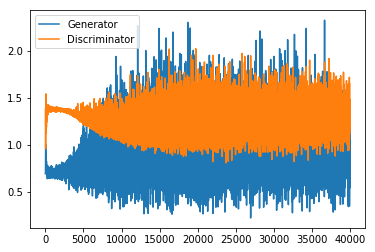

In [11]:
plt.plot(losses['G'], label='Generator')
plt.plot(losses['D'], label='Discriminator')
plt.legend()
plt.show()

In [12]:
G.eval()

Generator(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

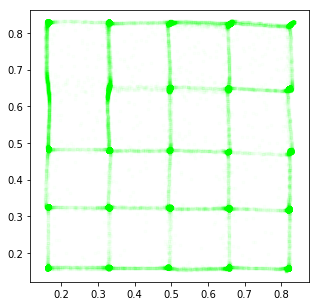

In [13]:
plt.gcf().set_size_inches(5, 5)

z_fake = noise_sampler.get_batch(100000)
generated = G(z_fake.to(params['device'])).detach().cpu().numpy()

plt.scatter(generated[:,0], generated[:,1], marker='.', color=(0, 1, 0, 0.01))
plt.axis('equal')
plt.show()